### Imports

In [1]:
print("Starting") # en demograficos tengo el GENDER
import os
import dask.dataframe as dd
import datetime
import pandas as pd

# os.environ["MODIN_CPUS"] = "38"
# import modin.pandas as pd_modin
# os.environ["MODIN_ENGINE"] = "dask"

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import boto3
import pickle
import numpy as np
from sklearn.metrics import mean_squared_error,average_precision_score
import joblib
import seaborn as sns
from bayes_opt import BayesianOptimization
#import lightgbm as lgb
import warnings
from sklearn.preprocessing import label_binarize
from multiprocessing import  cpu_count,Pool
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from lifetimes import ModifiedBetaGeoFitter
from lifetimes import GammaGammaFitter
from dateutil.relativedelta import relativedelta 
from lifetimes.utils import summary_data_from_transaction_data
import re
from unicodedata import normalize
# from shared import util
import gc
from sklearn.utils import class_weight
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
import pyarrow

import time
import shutil

# import sys
import sys
sys.path.append(os.path.dirname(os.path.expanduser(".")))
sys.path.append(os.path.dirname(os.path.expanduser("..")))
sys.path.append(os.path.dirname(os.path.expanduser("../defines")))
from defines import *

# import boto3
# s3 = boto3.client('s3')
# s3.download_file("fury-data-apps", "marketing-utils/pzenone/utils.py","utils.py")
# import utils

#from distributed import Client
#client = Client()

target_col = "frequency_eval"
TRAIN = True



Starting
NO se cargo ningun pais por defecto se carga: MCO


In [2]:
from google_cloud import BigQuery
from google_cloud import Storage
import base64
import os
bq = BigQuery(AUTH_BIGQUERY)
bqs = Storage(AUTH_BIGQUERY)

In [3]:
from preprocessing import *

from train_utils import train_combinations,simple_fit,foo_evaluation_regression, foo_model_regression,foo_predict_regression,anti_dummies,caster,picture

## Levanto todos los paises y calculo con BTYD

In [4]:
def preprocess(gcps_path_in):
    
    summary_cal = read_gfs_parquet(gcps_path_in, bqs, 'summary_cal')
    
    # Steps para preprocesar
    steps = []
    if (PAIS == 'MLB' or PAIS == 'MLA'):
        steps = steps + [prepaid,asset_mgm,install_mp]
    if (PAIS == 'MLB'):
        steps = steps + [reg_data]
    steps = steps + [orders_frequencies,IPT,locations,demograficos, compras_shipping, target, tarjetas, visitas_short,
         install_ml, payments, sellers, asp_pareto]

    # traigo base de clientes como pivot para añadir todas las columnas

    
    for func in steps:
        start = time.time()
        bqs.print_gcps("--------------------",bq_log_path=bq_log_path,silent = True)
        bqs.print_gcps("Start time:",datetime.datetime.now(),bq_log_path=bq_log_path,silent = True)
        bqs.print_gcps("Starting:",func.__name__,"Summary size:",summary_cal.shape,bq_log_path=bq_log_path)
        summary_cal = func(bqs, gcps_path_in,summary_cal,"train")
        end = time.time()
        bqs.print_gcps("tiempo en resolver:", end-start,bq_log_path=bq_log_path,silent = True)
    
    summary_cal = generate_clusters(bqs,gcps_path_in,summary_cal,"train_train")
    summary_cal = pareto(bqs,gcps_path_in,summary_cal,"train_train") # Genero modelo forecast
    
    return summary_cal

In [5]:
# Set fechas para descargar y joinear los datasets de entrenamiento

bqs.download_file(gcps_path_in + 'fechas.csv', 'fechas.csv')
fechas_queries = pd.read_csv('fechas.csv')
fechas_queries = [x for x in fechas_queries.Fecha.values]

In [6]:
summary_cal = preprocess(gcps_path_in)

Starting: orders_frequencies Summary size: (4802481, 98)
Starting: IPT Summary size: (4802481, 98)
Starting: locations Summary size: (4802481, 98)
Starting: demograficos Summary size: (4802481, 98)
Starting: compras_shipping Summary size: (4802481, 98)
Starting: target Summary size: (4802481, 98)
Starting: tarjetas Summary size: (4802481, 98)
Starting: visitas_short Summary size: (4802481, 98)
Starting: install_ml Summary size: (4802481, 98)
Starting: payments Summary size: (4802481, 99)
Starting: sellers Summary size: (4802481, 99)
Starting: asp_pareto Summary size: (4802481, 99)


In [7]:
def preparo_datos(summary_cal):
    
    numeric_dtypes = [np.dtype('float32'),np.dtype('float64'), np.dtype('int32'),np.dtype('int64')]

    total_cols = list(summary_cal.columns)
    if('CUS_CUST_ID' in total_cols): total_cols.remove('CUS_CUST_ID')
    
    # Evitar filtrar la variable target
    if(target_col in total_cols): total_cols.remove(target_col)
    
    # Eliminado de la query de Target, pero si lo vuelven a usar esta 
    if('GMV_TARGET' in total_cols): total_cols.remove('GMV_TARGET')
    
    
    train_cols_nocat = [x for x in total_cols if(summary_cal.dtypes[x] in numeric_dtypes)]
    
    cates = [x for x in total_cols if(summary_cal.dtypes[x] not in numeric_dtypes)]

    for x in train_cols_nocat:
        summary_cal[x] = summary_cal[x].astype(int)
    for x in cates:
        summary_cal[x] = summary_cal[x].astype(str)
    
    
    return summary_cal,cates,train_cols_nocat


## Hago seleccion de variables imporantes por segmento

### Entreno

In [8]:
train_cols_by_segment = {0:[x for x in summary_cal.columns if x not in  ['CUS_CUST_ID', target_col,'GMV_TARGET']],
                        1:[x for x in summary_cal.columns if x not in  ['CUS_CUST_ID', target_col,'GMV_TARGET']],
                        2:[x for x in summary_cal.columns if x not in  ['CUS_CUST_ID', target_col,'GMV_TARGET']],
                        3:[x for x in summary_cal.columns if x not in  ['CUS_CUST_ID', target_col,'GMV_TARGET']]}

In [12]:
def modelo_by_segmento(summary_cal,l_train_cols, n_cluster, select_variables = False):
    summary_cal,cates,train_cols_nocat = preparo_datos(summary_cal[l_train_cols])
    train, valid= train_test_split(summary_cal,test_size=0.15,random_state=0)
    train_full, test= train_test_split(train,test_size=0.2,random_state=0)
    
    if (select_variables):
        if(train_full.shape[0] > 1e6):
            train, _= train_test_split(train_full,test_size=0.6,random_state=0)  # reduzco para entrenamieto
        else:
            train = train_full
    else:
        if(train_full.shape[0] > 600000):
            train, _= train_test_split(train_full,train_size=500000,random_state=0)  # reduzco para entrenamieto
            print("resampleo de",train_full.shape,"a",train.shape[0])

        else:
            train = train_full
        
    print("Train:",train.shape[0],"Test:",test.shape[0],"Valid;",valid.shape[0])
    X_train_ =  np.c_[train[train_cols_nocat].values,train[cates].values]
    X_train_full =  np.c_[train_full[train_cols_nocat].values,train_full[cates].values]
    X_valid_ =  np.c_[valid[train_cols_nocat].values,valid[cates].values]
    X_test =  np.c_[test[train_cols_nocat].values,test[cates].values]

    y_train_full =  np.array(train_full[target_col])
    y_train_ =  np.array(train[target_col])
    y_valid_ =  np.array(valid[target_col])
    y_test =  np.array(test[target_col])  

    cates_ind = [X_train_.shape[1] - len(cates) + i for i in range(len(cates))]  # indices de las categorias

    # Entreno    
    basic_params = {
        
               'use_best_model':True,
               'loss_function': 'MAE',
                'eval_metric':'MAE',
                'verbose':False,
                'boosting_type':"Plain",
                'bootstrap_type':"Bernoulli",
                'iterations':500,
    #              'class_weights':weights_l,
    #              'rsm':0.1,  # OJO!!! esto solo va si tenes mas de 100 features!,
    #             'max_ctr_complexity':2,
               'random_state': 45
            }


    
    hyperparams = { 
                    'learning_rate':[0.01,0.05,0.1,0.2,0.3],
                    'depth': [1,3,5,7,10],                                                       
                    'l2_leaf_reg': [1,10,50,100,150,300,500,750,1000],
                    'border_count': [5,10,30,60,100,150,200]
                }

    d_types = { 'depth': int,
               'l2_leaf_reg': int,
               'border_count':int
              }

    if select_variables:
        
        params = train_combinations(X_train_,X_valid_,y_train_,y_valid_,"neg_mean_absolute_error",foo_predict_regression,
                              foo_model_regression,basic_params,d_types,hyperparams,cates_ind, n_iter = SELECT_VARIABLES_STEPS)
        best_model =  simple_fit(params,X_train_full,y_train_full,X_valid_,y_valid_,foo_model_regression,basic_params,d_types,cates_ind)
    
    else:
        params = train_combinations(X_train_,X_valid_,y_train_,y_valid_,"neg_mean_absolute_error",foo_predict_regression,
                          foo_model_regression,basic_params,d_types,hyperparams,cates_ind,log="training.txt", n_iter = FULL_TRAINING_STEPS)
        #params = train_combinations(X_train_,X_valid_,y_train_,y_valid_,"neg_mean_absolute_error",foo_predict_regression,
        #                  foo_model_regression,basic_params,d_types,hyperparams,cates_ind,log="training.txt")

        
        bqs.print_gcps("Ready Randomsearch",bq_log_path=bq_log_path)
        best_model =  simple_fit(params,X_train_full,y_train_full,X_valid_,y_valid_,foo_model_regression,basic_params,d_types,cates_ind)
        bqs.print_gcps("Ready best model",bq_log_path=bq_log_path)
        error = foo_evaluation_regression(y_test,foo_predict_regression(best_model,X_test))
        bqs.print_gcps("Error:",error,bq_log_path=bq_log_path)
    
    c = n_cluster
    imp = picture(np.r_[X_train_,X_valid_],np.r_[y_train_,y_valid_],X_test,y_test,cates_ind,best_model,foo_model_regression,train_cols_nocat,cates)
    bqs.upload_file("lgbmImportance.png", gcps_path_out + "lgbmImportance_"+str(c)+".png")
    
    if select_variables:
        imp.sort_values('Value', ascending = False).to_csv("importance_short_"+str(c)+".csv",index=False)
    else:
        imp.sort_values('Value', ascending = False).to_csv("importance_full_"+str(c)+".csv",index=False)
    
    if not select_variables:
        bqs.upload_file("importance_full_"+str(c)+".csv", gcps_path_out + "importance_"+str(c)+".csv")
    
    if select_variables:
        return best_model, 0
    else:
        return best_model, error

-------- ENTRENAMIENTO 0 -------
Train: 424747 Test: 265468 Valid; 234236
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START border_count=60, depth=1, l2_leaf_reg=10, learning_rate=0.3
[CV 2/3; 1/10] START border_count=60, depth=1, l2_leaf_reg=10, learning_rate=0.3
[CV 3/3; 1/10] START border_count=60, depth=1, l2_leaf_reg=10, learning_rate=0.3
[CV 1/3; 2/10] START border_count=30, depth=5, l2_leaf_reg=100, learning_rate=0.3
[CV 2/3; 2/10] START border_count=30, depth=5, l2_leaf_reg=100, learning_rate=0.3
[CV 3/3; 2/10] START border_count=30, depth=5, l2_leaf_reg=100, learning_rate=0.3
[CV 1/3; 3/10] START border_count=150, depth=5, l2_leaf_reg=1, learning_rate=0.05
[CV 2/3; 3/10] START border_count=150, depth=5, l2_leaf_reg=1, learning_rate=0.05
[CV 3/3; 3/10] START border_count=150, depth=5, l2_leaf_reg=1, learning_rate=0.05
[CV 1/3; 4/10] START border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01
[CV 1/3; 1/10] END border_count=60, depth=1, l2


[CV 2/3; 7/10] START border_count=100, depth=5, l2_leaf_reg=1000, learning_rate=0.2
[CV 2/3; 5/10] END border_count=60, depth=3, l2_leaf_reg=1000, learning_rate=0.2;, score=-1.116 total time= 3.6min
[CV 1/3; 4/10] END border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01;, score=-1.120 total time= 7.9min
[CV 3/3; 7/10] START border_count=100, depth=5, l2_leaf_reg=1000, learning_rate=0.2
[CV 2/3; 4/10] END border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01;, score=-1.113 total time= 7.8min
[CV 1/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 2/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 1/3; 6/10] END border_count=200, depth=1, l2_leaf_reg=500, learning_rate=0.2;, score=-1.162 total time= 3.2min
[CV 2/3; 6/10] END border_count=200, depth=1, l2_leaf_reg=500, learning_rate=0.2;, score=-1.126 total time= 2.8min
[CV 3/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 3/3; 4/10

[CV 3/3; 7/10] START border_count=100, depth=5, l2_leaf_reg=1000, learning_rate=0.2
[CV 3/3; 5/10] END border_count=60, depth=3, l2_leaf_reg=1000, learning_rate=0.2;, score=-0.542 total time= 5.9min
[CV 2/3; 4/10] END border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01;, score=-0.534 total time= 8.0min
[CV 1/3; 6/10] END border_count=200, depth=1, l2_leaf_reg=500, learning_rate=0.2;, score=-0.558 total time= 5.7min
[CV 2/3; 5/10] END border_count=60, depth=3, l2_leaf_reg=1000, learning_rate=0.2;, score=-0.538 total time= 6.3min
[CV 1/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 3/3; 4/10] END border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01;, score=-0.537 total time= 7.8min
[CV 2/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 2/3; 6/10] END border_count=200, depth=1, l2_leaf_reg=500, learning_rate=0.2;, score=-0.560 total time= 5.6min
[CV 3/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, l

[CV 1/3; 4/10] END border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01;, score=-2.881 total time= 3.8min
[CV 3/3; 7/10] START border_count=100, depth=5, l2_leaf_reg=1000, learning_rate=0.2
[CV 1/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 1/3; 6/10] END border_count=200, depth=1, l2_leaf_reg=500, learning_rate=0.2;, score=-2.886 total time= 1.3min
[CV 2/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 3/3; 6/10] END border_count=200, depth=1, l2_leaf_reg=500, learning_rate=0.2;, score=-2.855 total time= 1.3min
[CV 2/3; 6/10] END border_count=200, depth=1, l2_leaf_reg=500, learning_rate=0.2;, score=-2.841 total time= 1.4min
[CV 3/3; 8/10] START border_count=10, depth=3, l2_leaf_reg=10, learning_rate=0.1
[CV 1/3; 9/10] START border_count=30, depth=7, l2_leaf_reg=50, learning_rate=0.3
[CV 2/3; 5/10] END border_count=60, depth=3, l2_leaf_reg=1000, learning_rate=0.2;, score=-2.816 total time= 1.6min
[CV 3/3; 4/10] EN

[CV 2/3; 4/10] START border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01
[CV 3/3; 1/10] END border_count=60, depth=1, l2_leaf_reg=10, learning_rate=0.3;, score=-0.262 total time= 3.3min
[CV 3/3; 4/10] START border_count=60, depth=7, l2_leaf_reg=300, learning_rate=0.01
[CV 1/3; 5/10] START border_count=60, depth=3, l2_leaf_reg=1000, learning_rate=0.2
[CV 1/3; 2/10] END border_count=30, depth=5, l2_leaf_reg=100, learning_rate=0.3;, score=-0.262 total time= 4.4min
[CV 1/3; 3/10] END border_count=150, depth=5, l2_leaf_reg=1, learning_rate=0.05;, score=-0.263 total time= 4.3min
[CV 2/3; 5/10] START border_count=60, depth=3, l2_leaf_reg=1000, learning_rate=0.2
[CV 2/3; 2/10] END border_count=30, depth=5, l2_leaf_reg=100, learning_rate=0.3;, score=-0.262 total time= 4.7min
[CV 3/3; 5/10] START border_count=60, depth=3, l2_leaf_reg=1000, learning_rate=0.2
[CV 3/3; 2/10] END border_count=30, depth=5, l2_leaf_reg=100, learning_rate=0.3;, score=-0.262 total time= 4.8min
[CV 1/3; 6/10] S

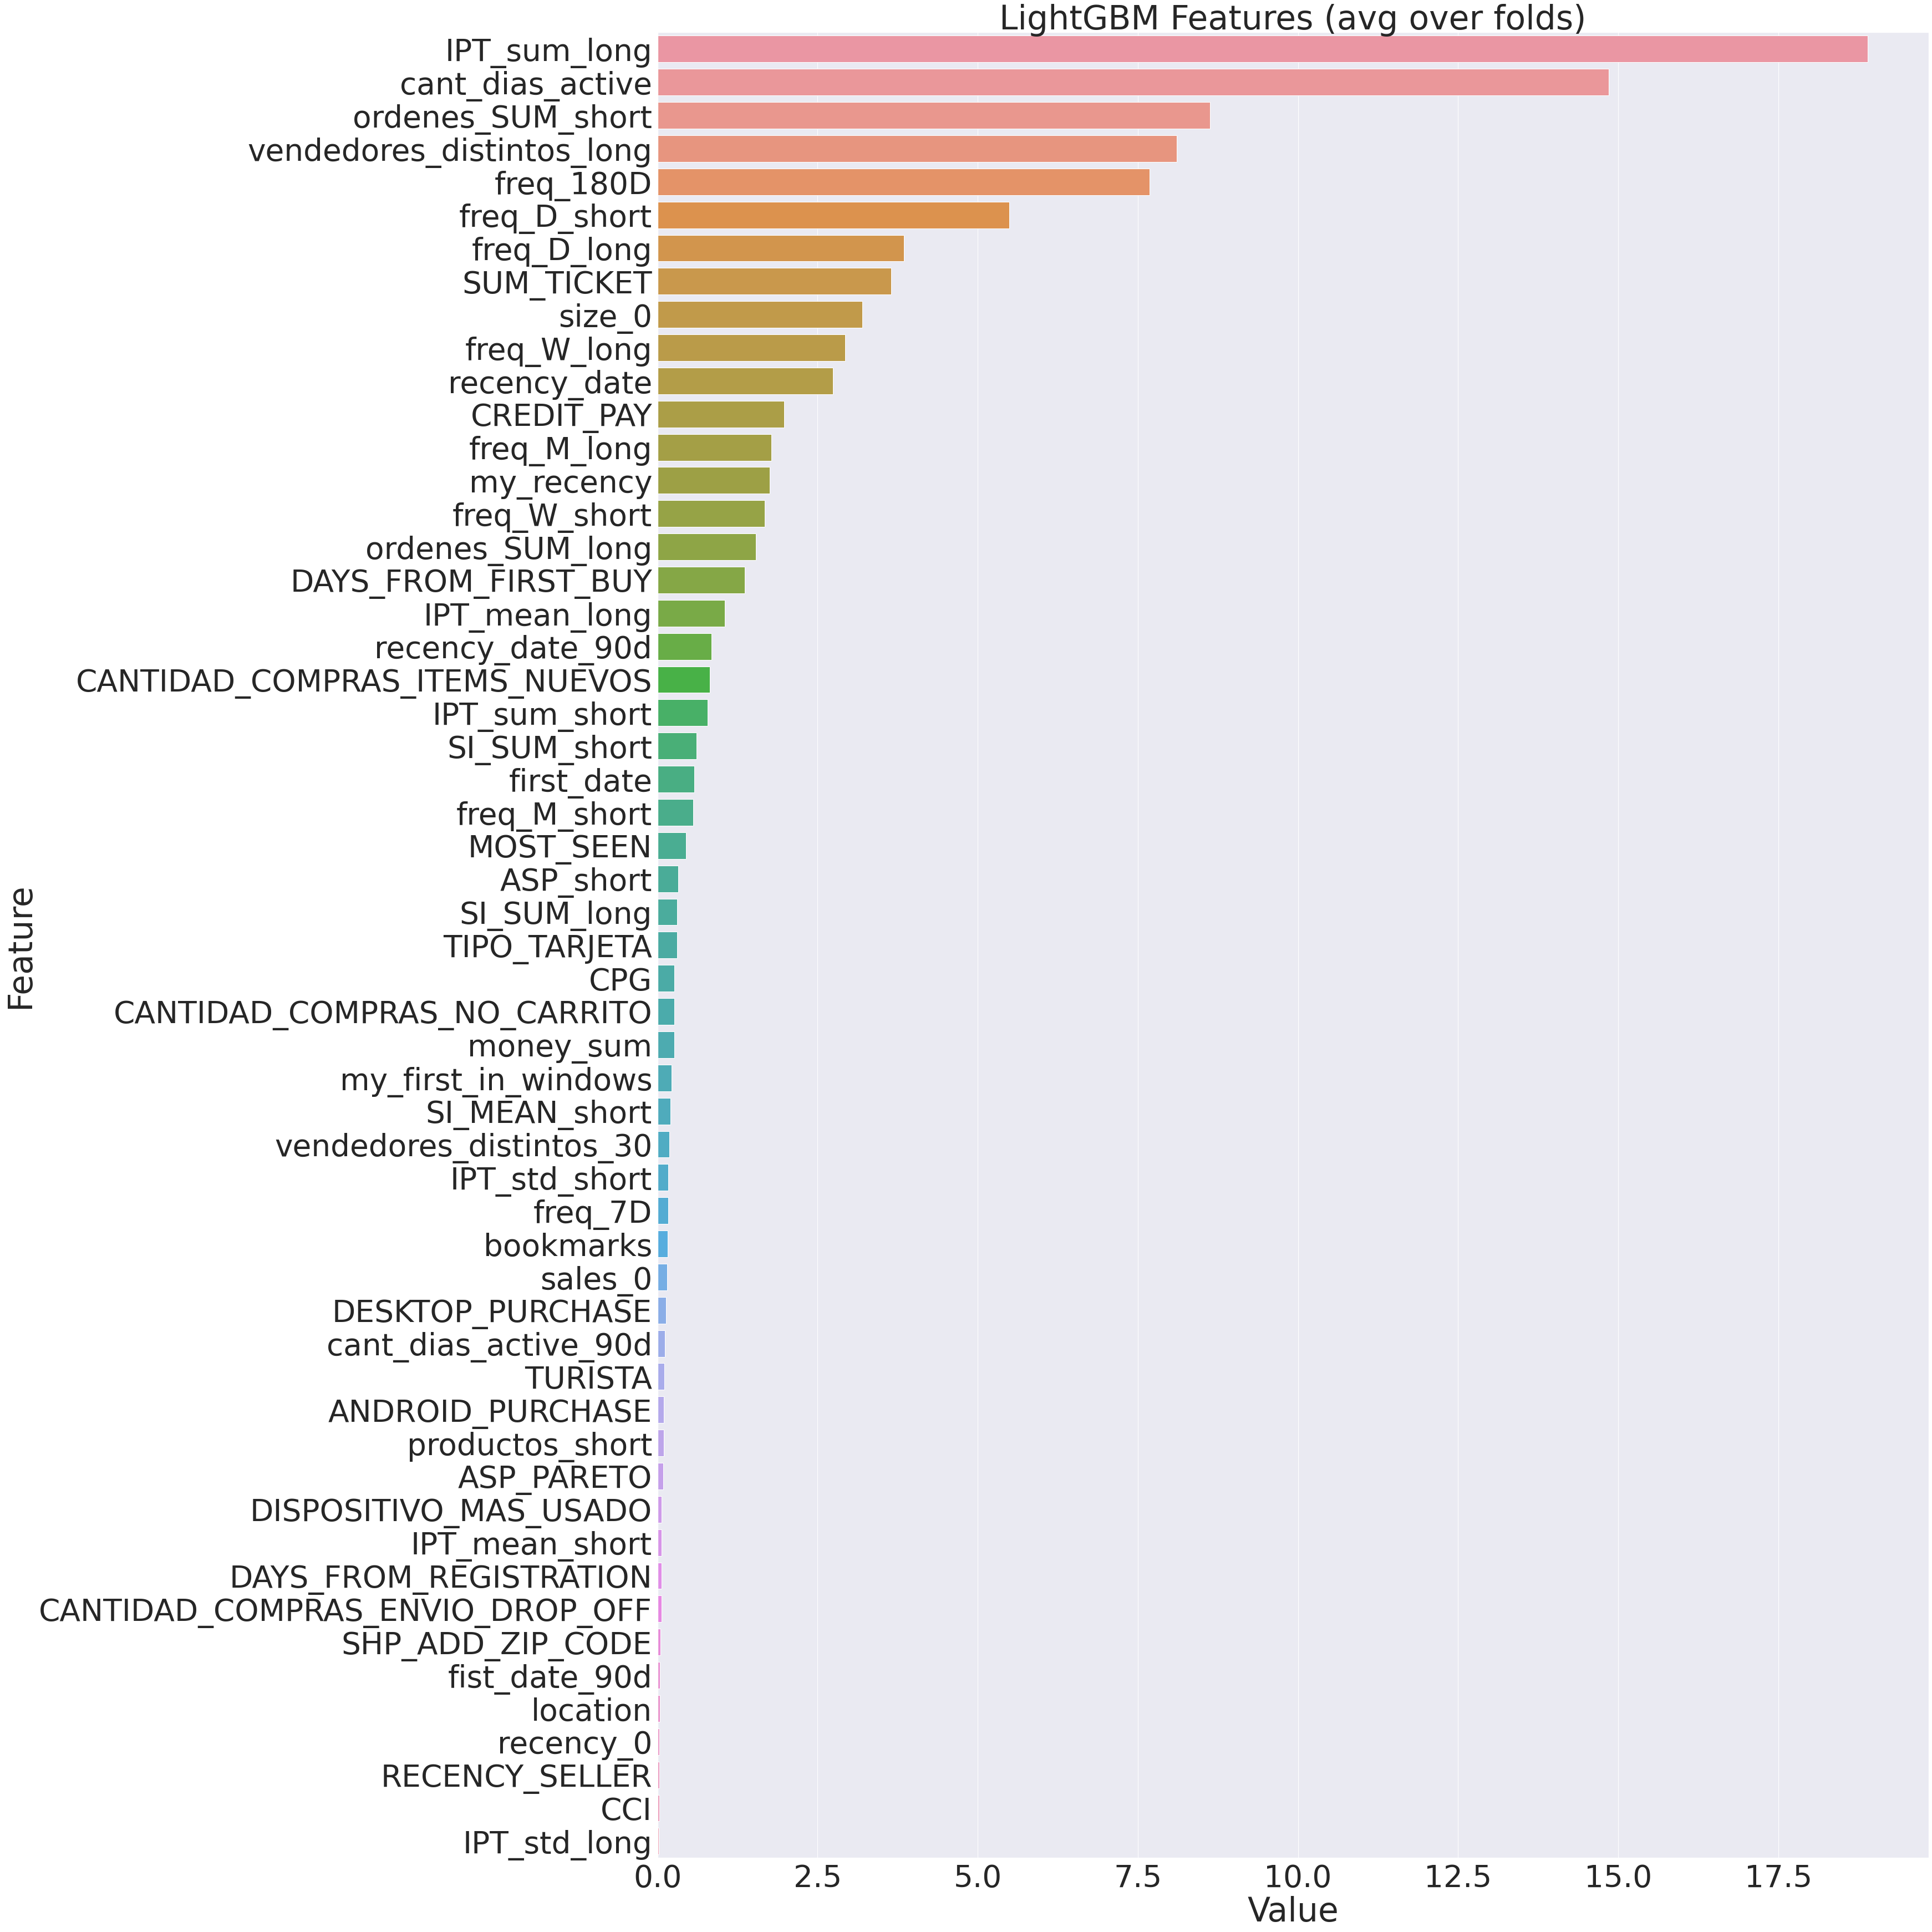

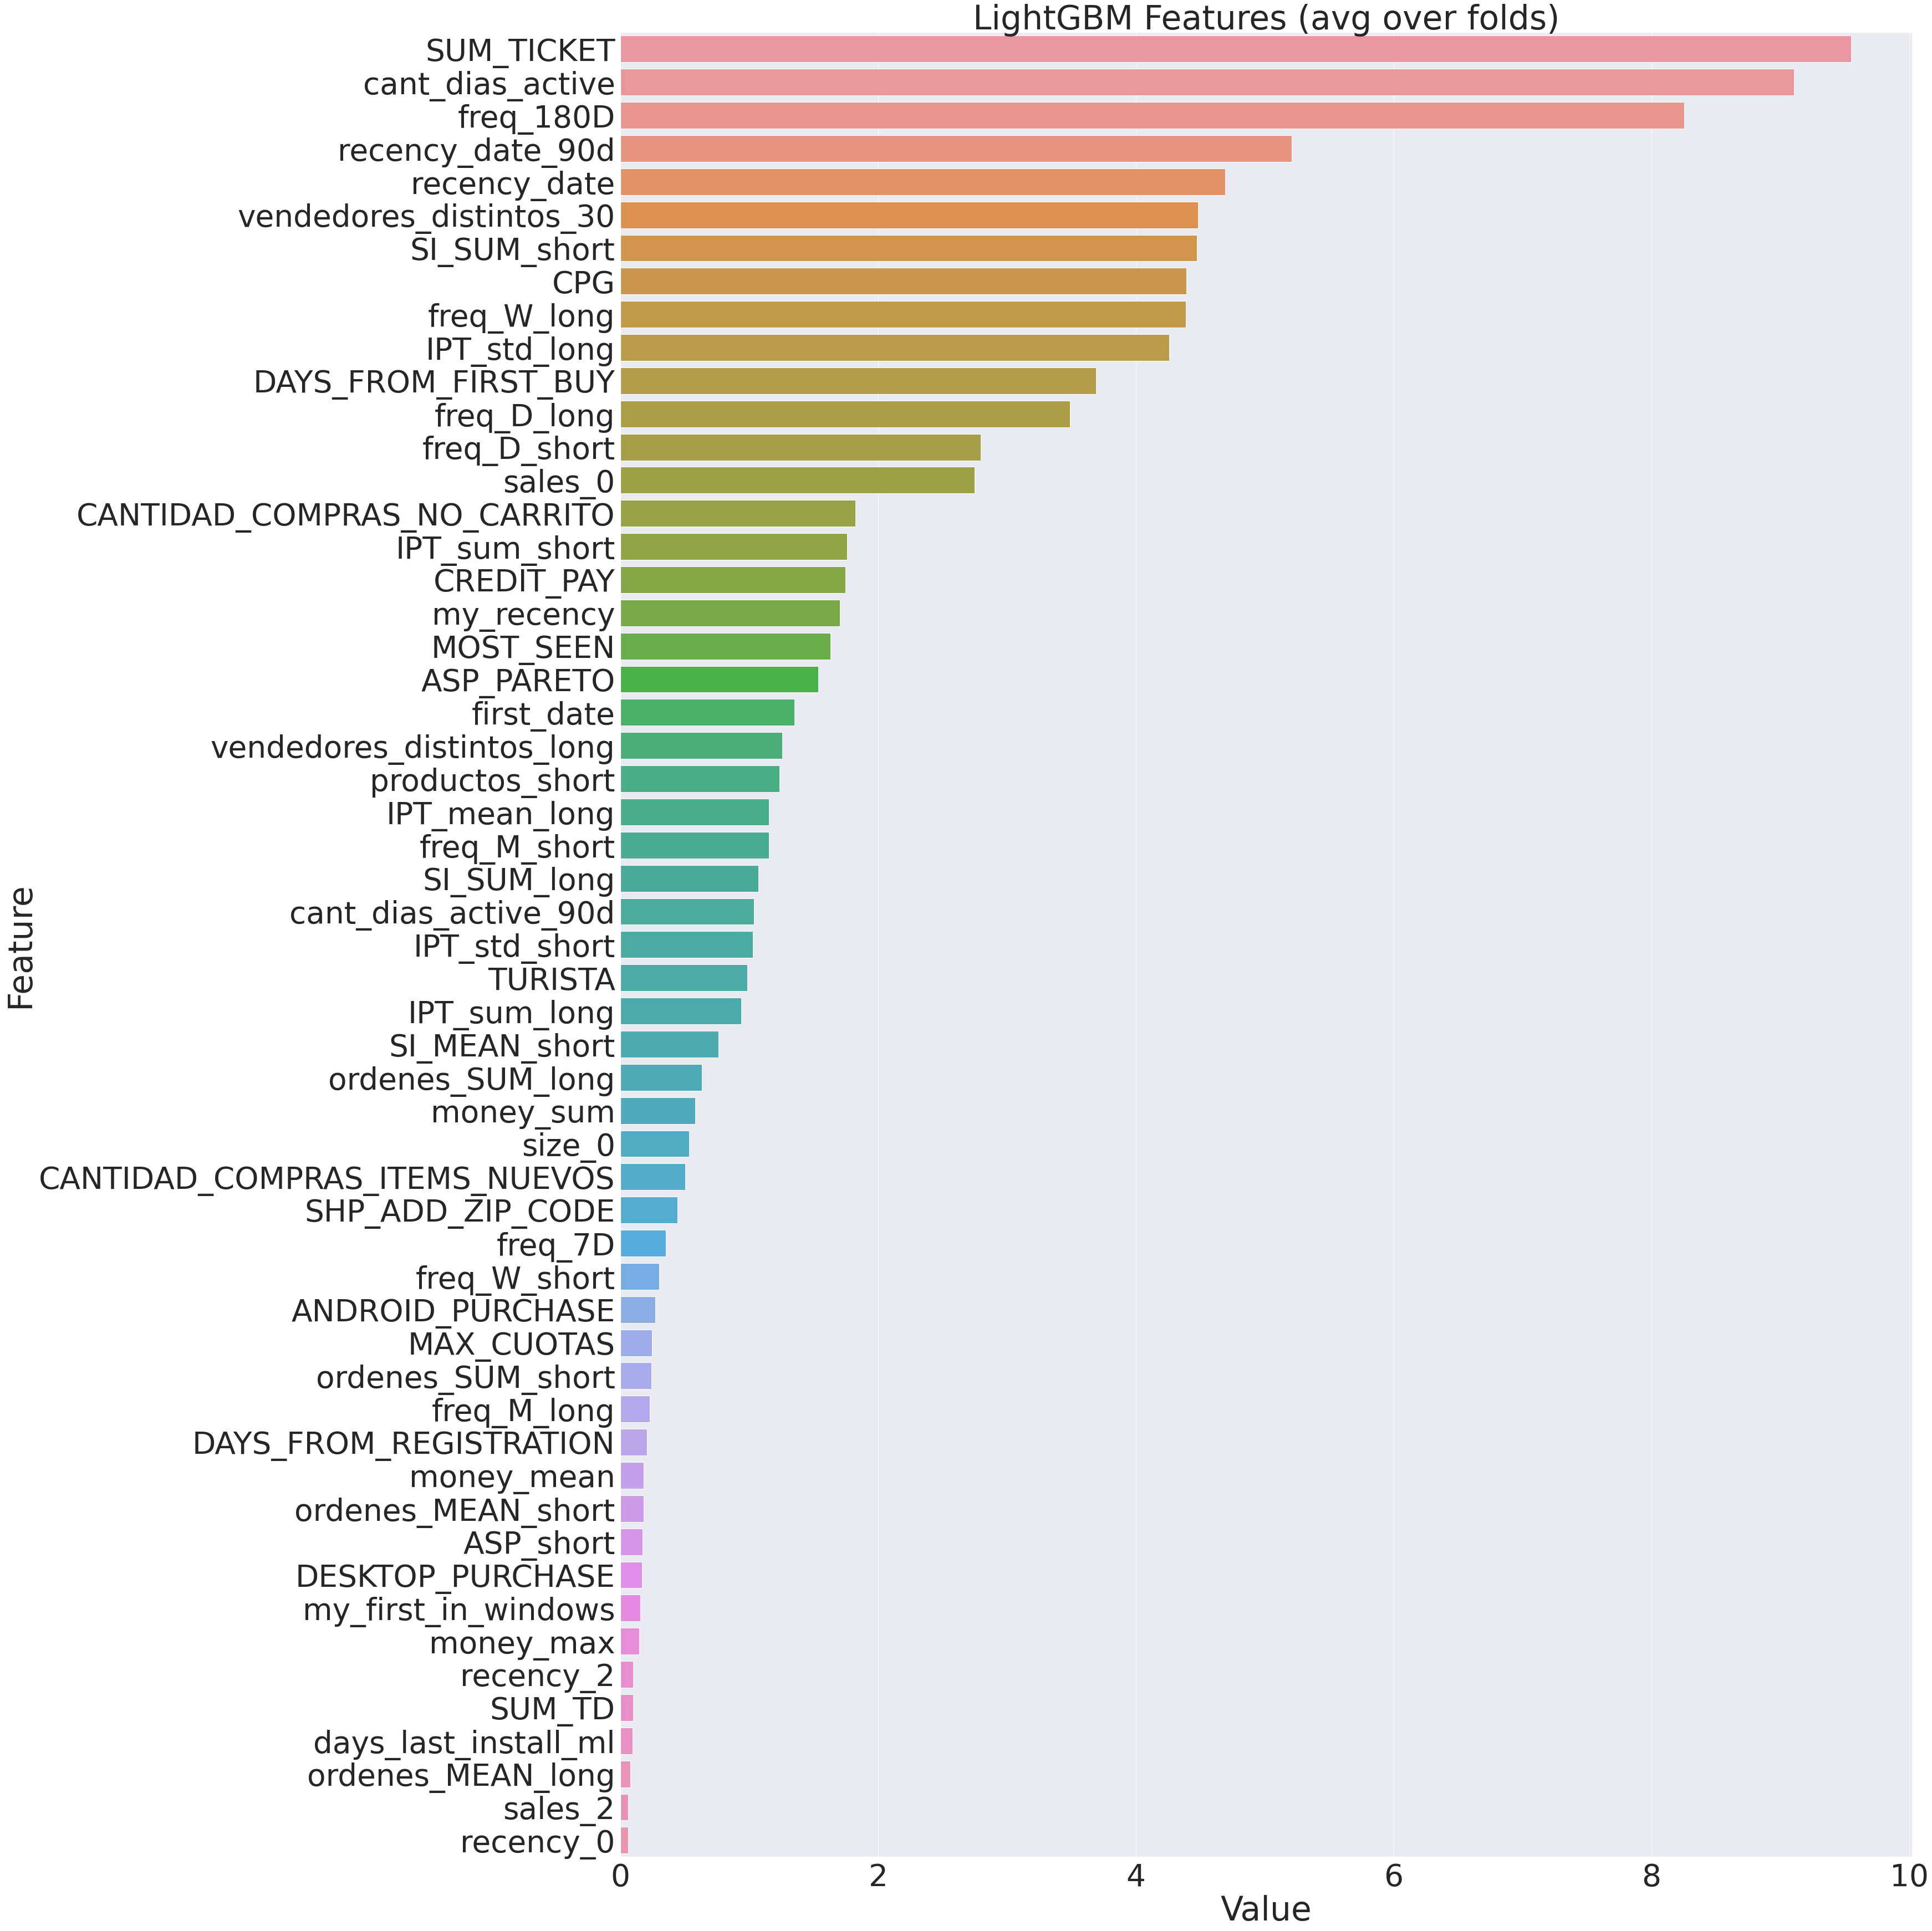

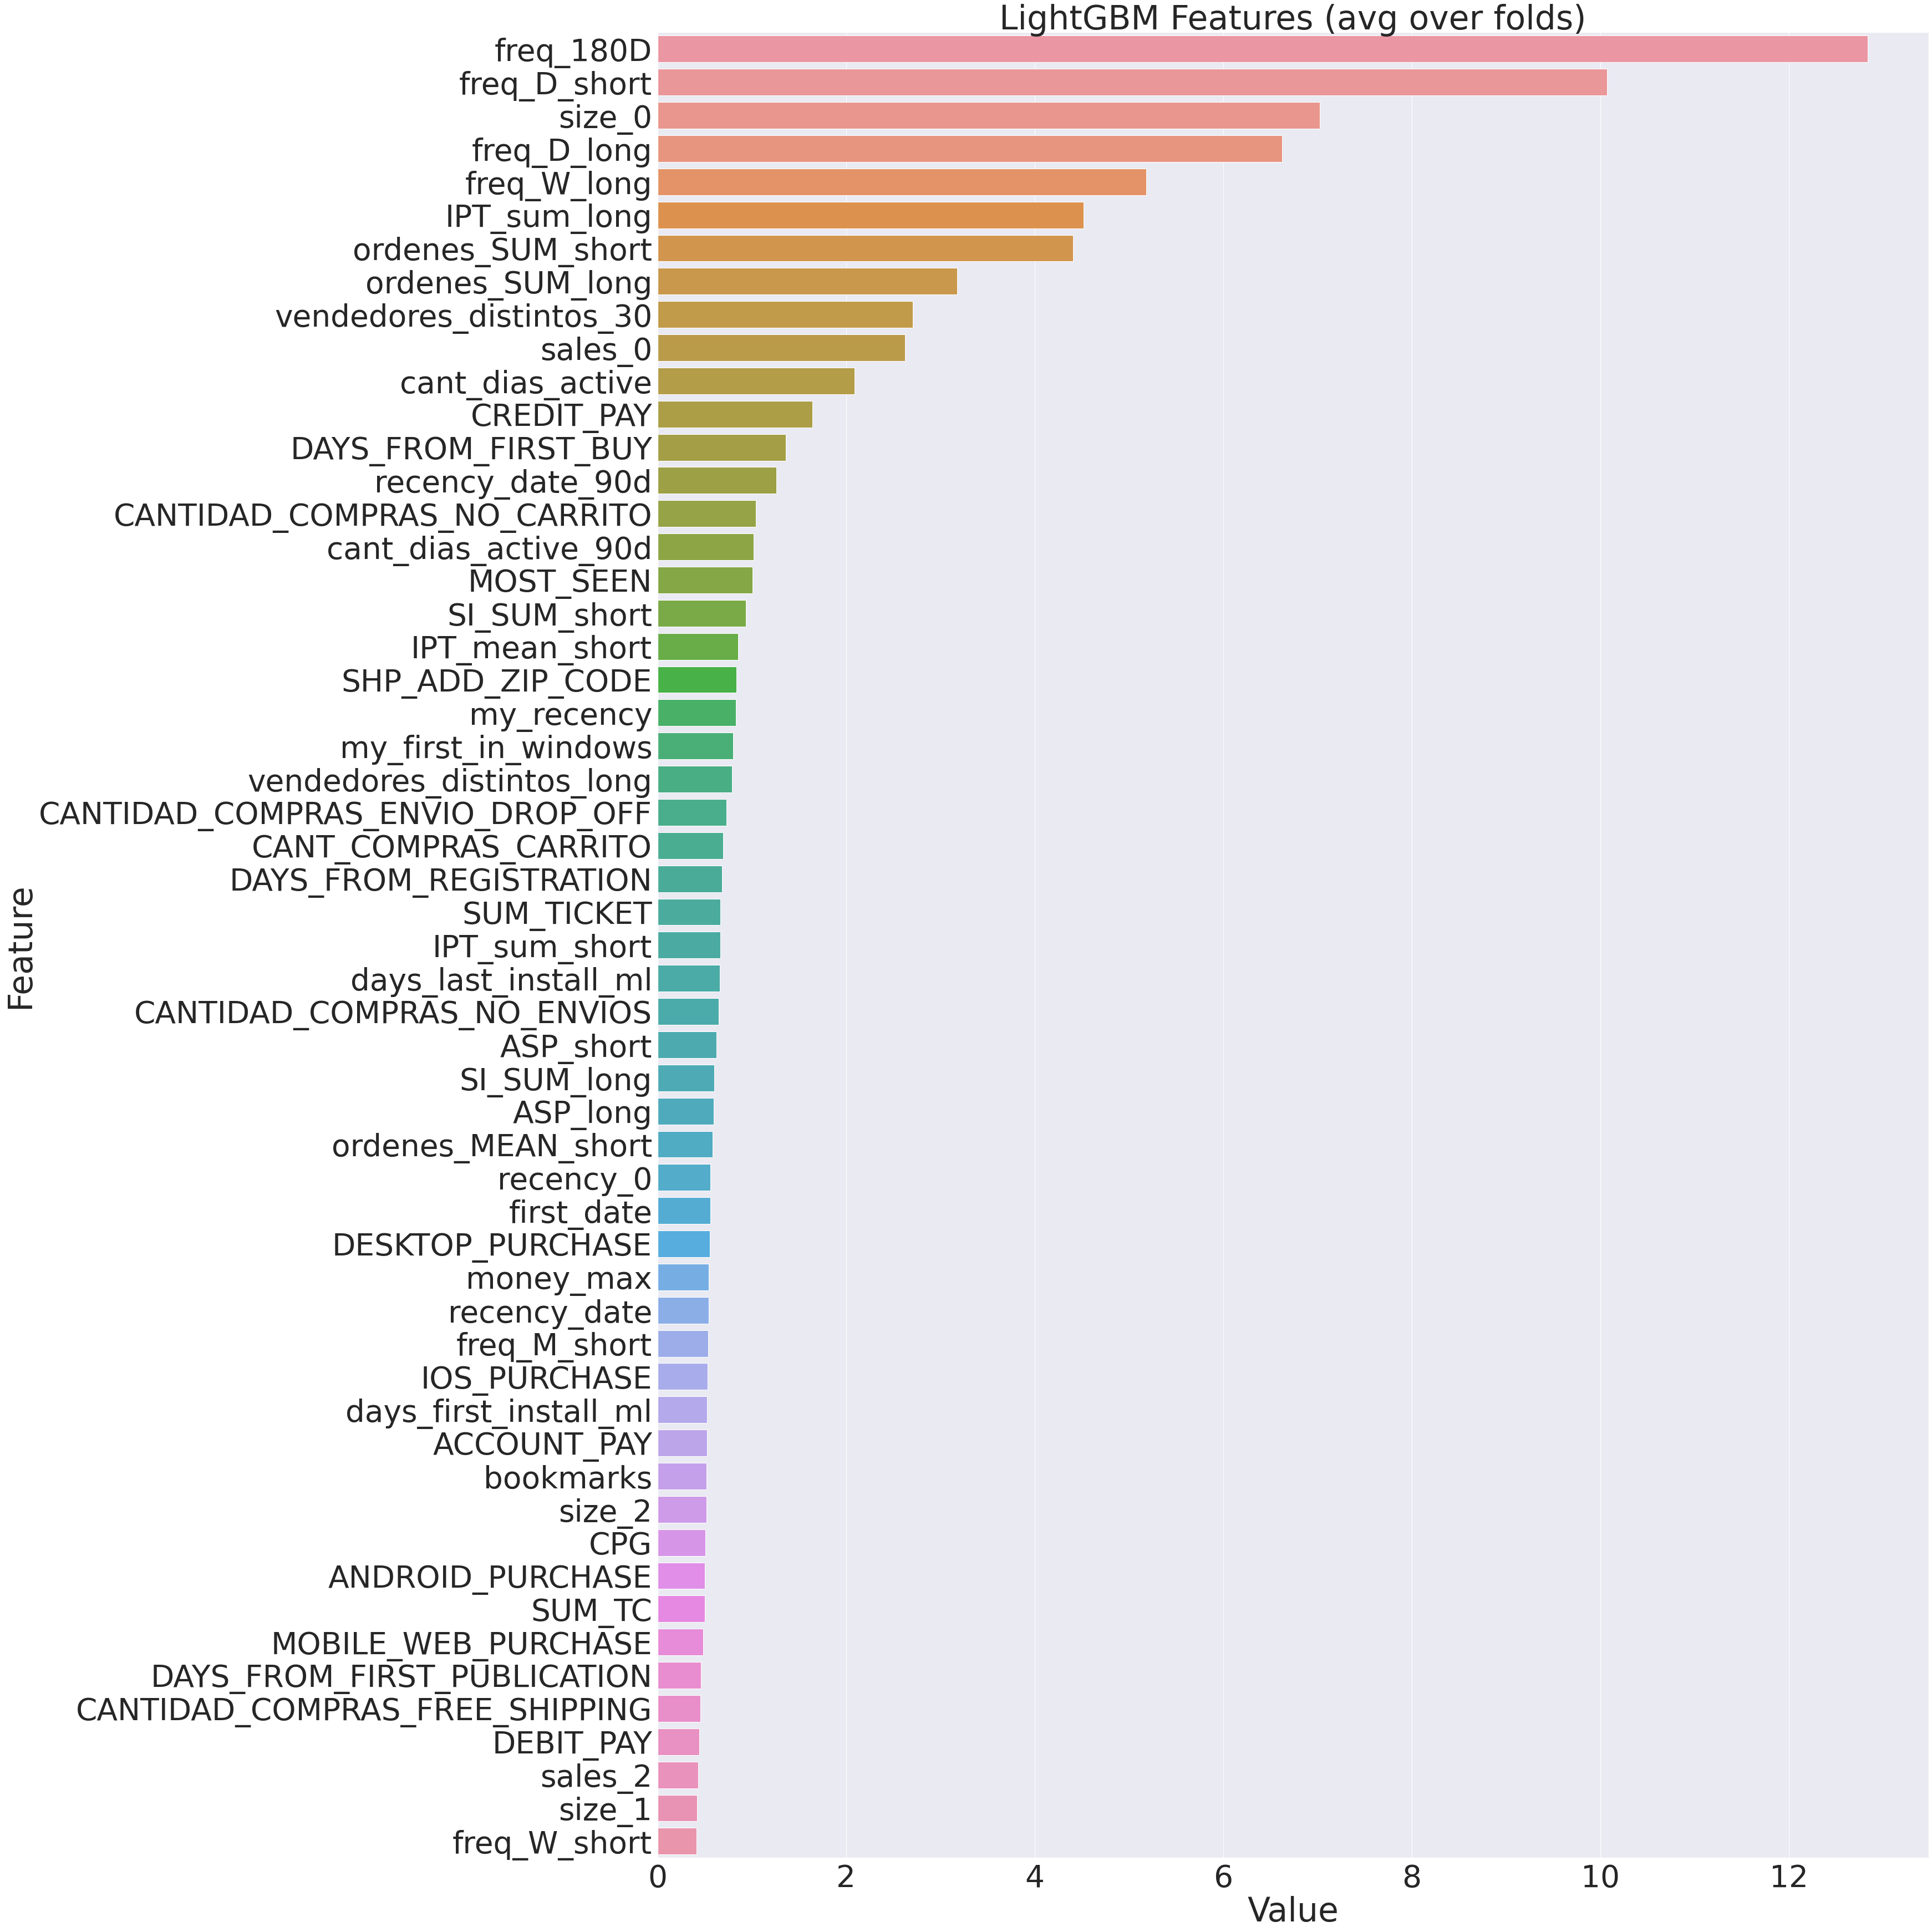

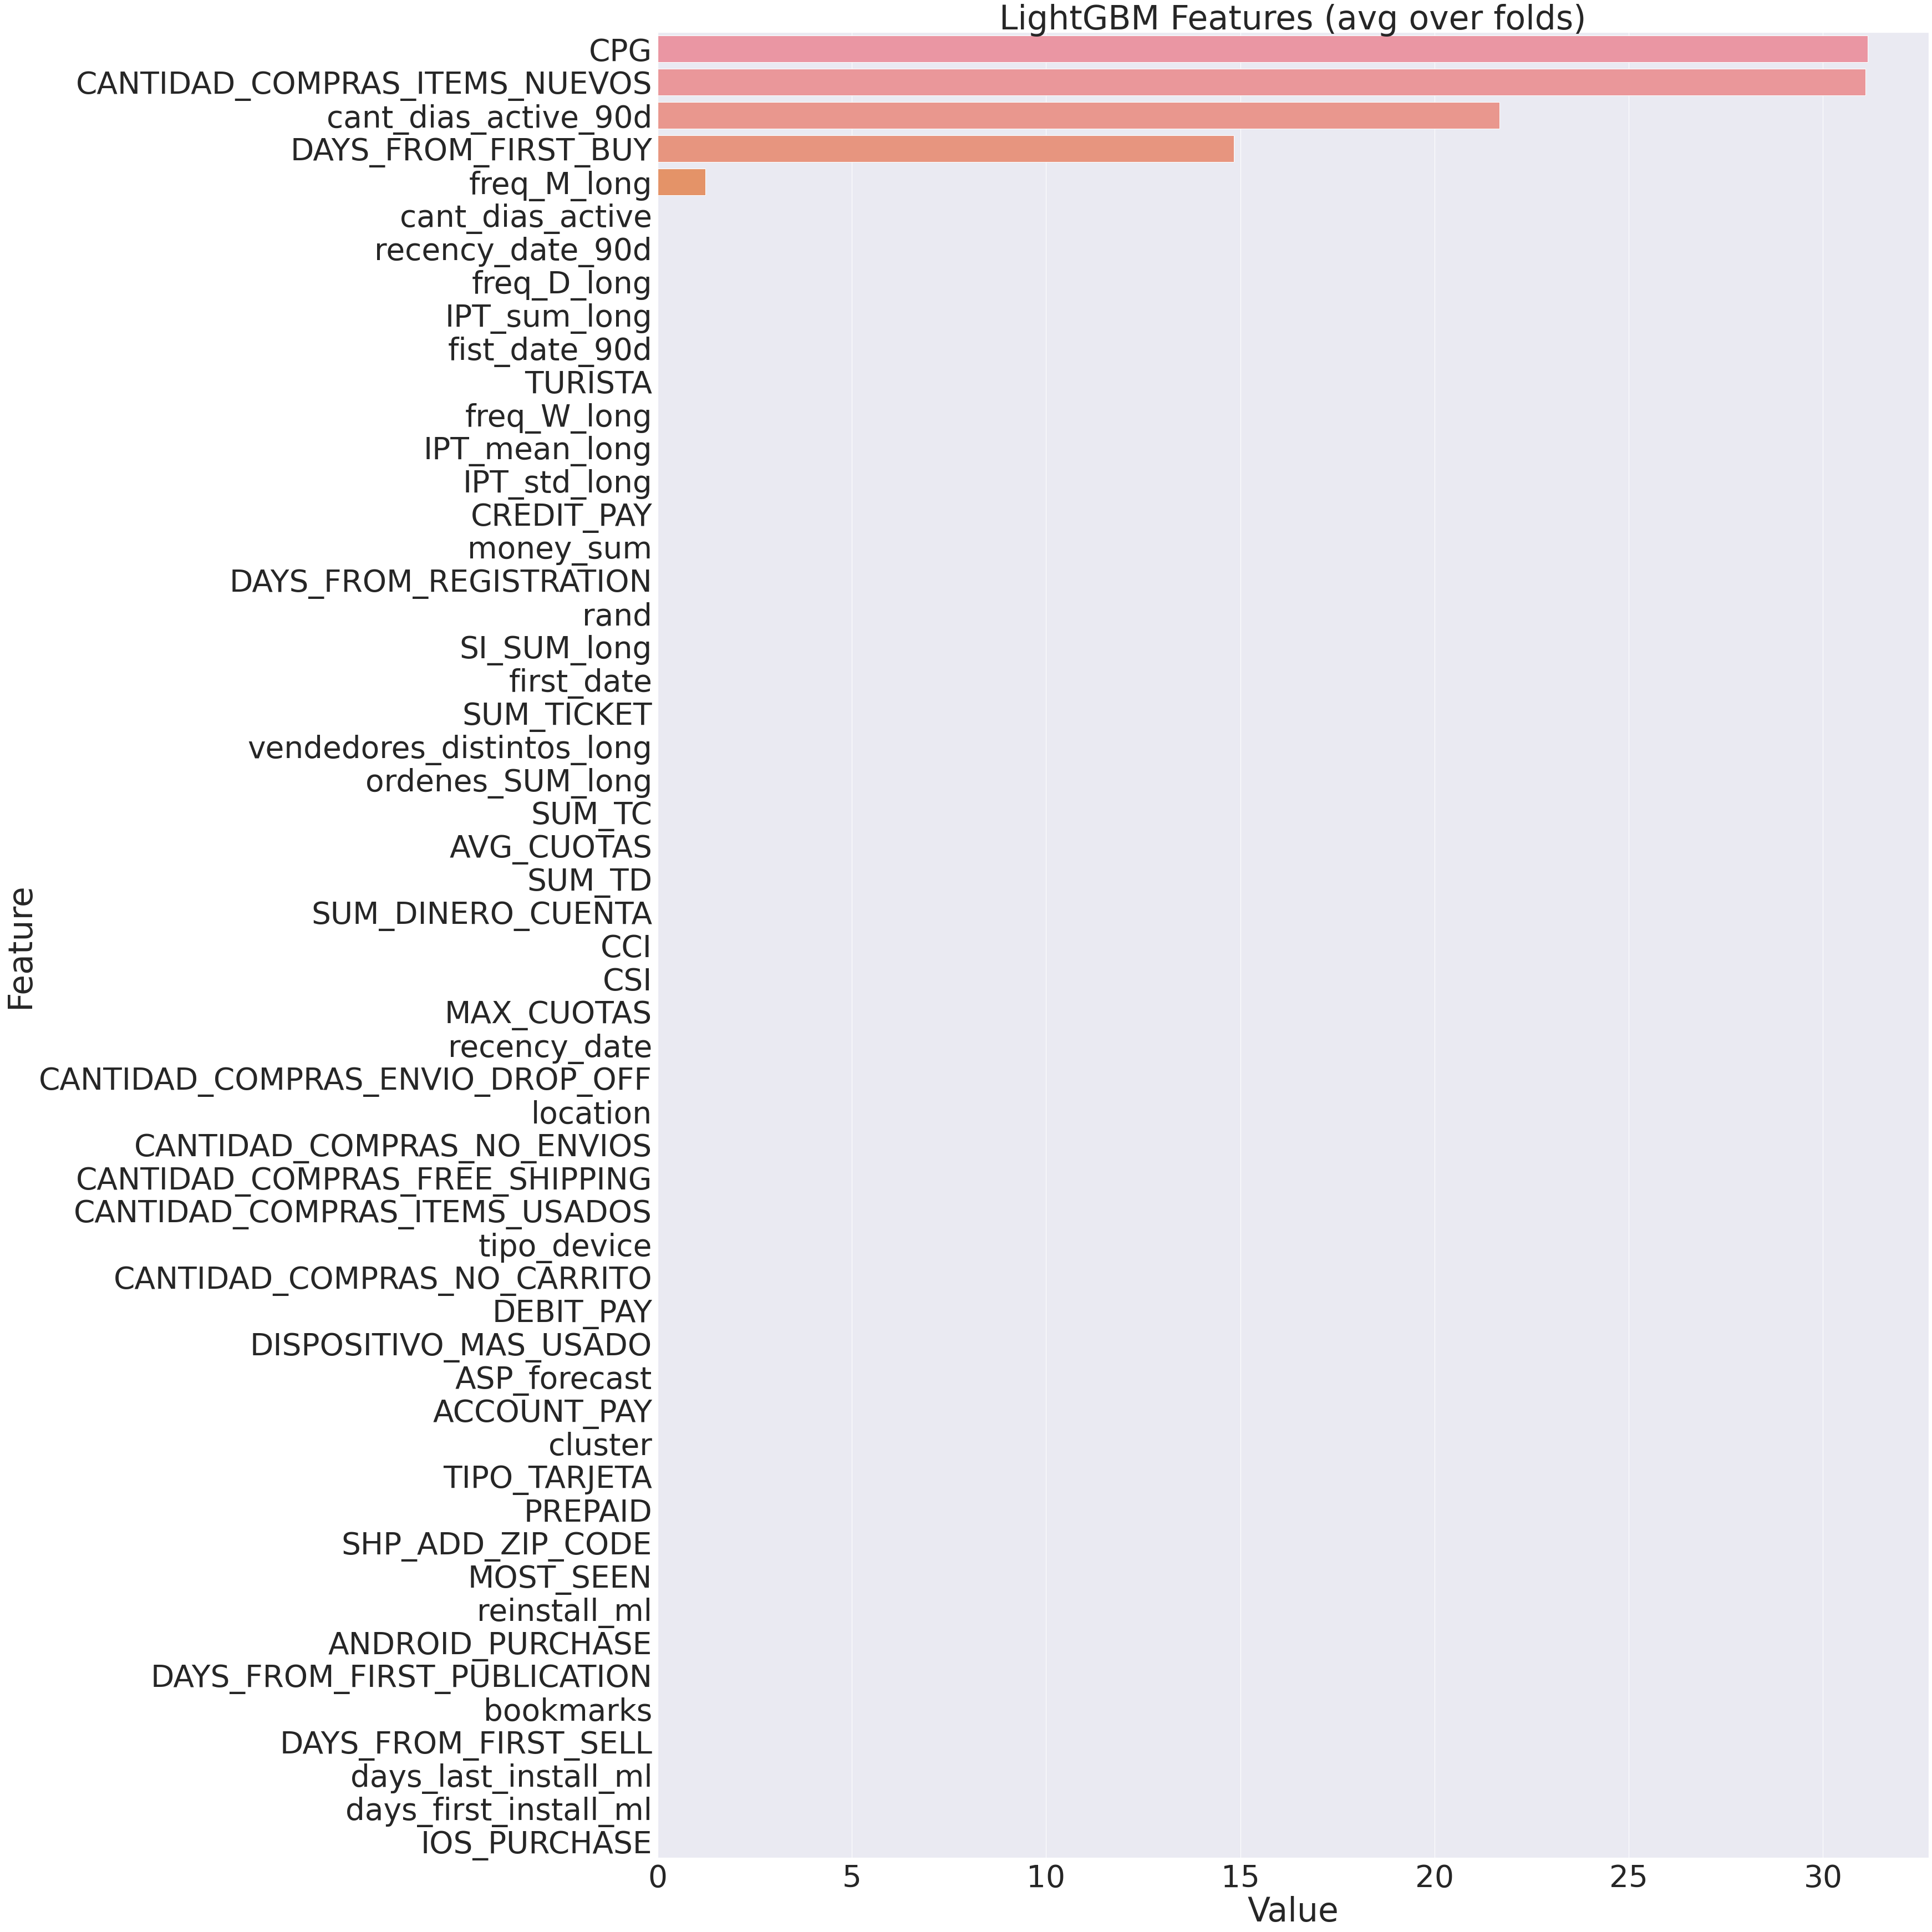

In [13]:
#Modelo reducido para la busqueda de variables importantes

for c in range(N_CLUSTERS):
        bqs.print_gcps("-------- ENTRENAMIENTO {} -------".format(c),bq_log_path=bq_log_path)
        
        #bqs.download_file(gcps_path_in + f'summary_train_{str(c)}.pkl', f'summary_train_{str(c)}.pkl')
        #summary_cal = pd.read_pickle(f'summary_train_{str(c)}.pkl')
        summary_cluster = summary_cal.loc[summary_cal.cluster == c]
        #Corro entrenamiento corto para el cluster seleccionado
        model, error = modelo_by_segmento(summary_cluster,summary_cluster.columns, c, select_variables = True) #modelo para ese segmento

        with open("model_short_"+str(c)+".pkl", 'wb') as file: # guardo
            pickle.dump(model, file)

        gc.collect()

In [14]:
# Busqueda de variables importancia en relacion a la variable 'random'

for n in range(N_CLUSTERS):
    imp = pd.read_csv(f'importance_short_{n}.csv').sort_values('Value', ascending = False)
    
    max_importance = imp.iloc[1,1]
    rand_importance = imp.loc[imp.Feature == 'rand'].values[0][1]
    
    print(f"{n}_max_importance: {max_importance}")
    print(f"{n}_rand_importance: {rand_importance}")
    
    mayores_a_rand = list(imp.loc[imp.Value > rand_importance].Feature)
    mayores_orden_4 = list(imp.loc[imp.Value >= (max_importance / 1000)].Feature)
    distinto_0 = list(imp.loc[imp.Value > 0.0].Feature)
    
    total_vars = [x for x in list(imp.Feature) if (x in mayores_a_rand) and (x in mayores_orden_4) and (x in distinto_0)]
    
    print(f" Variables Cluster {n}: {len(total_vars)}")
    pd.DataFrame(total_vars, columns = ['Feature']).to_csv(f"features_model_{n}.csv", index = False)
    
    # Subo features del modelo N al Storage, incluidos el cluster y la columna target
    bqs.upload_file(f"features_model_{n}.csv", gcps_path_out + f"features_model_{n}.csv")

0_max_importance: 14.851111701178526
0_rand_importance: 0.0
 Variables Cluster 0: 58
1_max_importance: 9.104915506239912
1_rand_importance: 0.0
 Variables Cluster 1: 64
2_max_importance: 10.07181535129484
2_rand_importance: 0.246733847929616
 Variables Cluster 2: 72
3_max_importance: 31.091479945085094
3_rand_importance: 2.34790766513123e-41
 Variables Cluster 3: 5


In [ ]:
# Entrenamiento del modelo Full productivo

errores = []
for c in range(N_CLUSTERS):
#for c in range(1):
    train_cols = train_cols_by_segment[c]
    bqs.print_gcps("-------- ENTRENAMIENTO {} -------".format(c), bq_log_path = bq_log_path)

    #bqs.download_file(gcps_path_in + "summary_train_"+str(c)+".pkl", "summary_train_"+str(c)+".pkl")
    #summary_cal = pd.read_pickle("summary_train_"+str(c)+".pkl")

    #Variables importantes procesadas en el paso previo + Target
    variables = list(pd.read_csv(f"features_model_{c}.csv").Feature) + [target_col]
    summary_cluster = summary_cal.loc[summary_cal.cluster == c]
    #summary_cal,cates,no_cates = preparo_datos(summary_cal)
    # Modelo para ese segmento (Cluster)
    model,error = modelo_by_segmento(summary_cluster,variables, c, select_variables = False)
    errores.append(error)
    
    with open("model_"+str(c)+".pkl", 'wb') as file:
        pickle.dump(model, file)
        
    bqs.upload_file("model_"+str(c)+".pkl", gcps_path_out + "model_"+str(c)+".pkl")
    gc.collect()

-------- ENTRENAMIENTO 0 -------
resampleo de (1061869, 59) a 500000
Train: 500000 Test: 265468 Valid; 234236
[CV 1/3; 1/150] START border_count=200, depth=7, l2_leaf_reg=10, learning_rate=0.05
[CV 2/3; 1/150] START border_count=200, depth=7, l2_leaf_reg=10, learning_rate=0.05
[CV 3/3; 1/150] START border_count=200, depth=7, l2_leaf_reg=10, learning_rate=0.05
[CV 1/3; 2/150] START border_count=5, depth=1, l2_leaf_reg=100, learning_rate=0.2
[CV 2/3; 2/150] START border_count=5, depth=1, l2_leaf_reg=100, learning_rate=0.2
[CV 3/3; 2/150] START border_count=5, depth=1, l2_leaf_reg=100, learning_rate=0.2
[CV 1/3; 3/150] START border_count=10, depth=1, l2_leaf_reg=10, learning_rate=0.2
[CV 2/3; 3/150] START border_count=10, depth=1, l2_leaf_reg=10, learning_rate=0.2
[CV 3/3; 3/150] START border_count=10, depth=1, l2_leaf_reg=10, learning_rate=0.2
[CV 1/3; 4/150] START border_count=150, depth=3, l2_leaf_reg=500, learning_rate=0.2
[CV 2/3; 2/150] END border_count=5, depth=1, l2_leaf_reg=100, 

[CV 3/3; 7/150] START border_count=5, depth=3, l2_leaf_reg=10, learning_rate=0.2
[CV 3/3; 4/150] END border_count=150, depth=3, l2_leaf_reg=500, learning_rate=0.2;, score=-1.125 total time= 3.3min
[CV 1/3; 8/150] START border_count=100, depth=5, l2_leaf_reg=150, learning_rate=0.2
[CV 1/3; 5/150] END border_count=10, depth=3, l2_leaf_reg=1, learning_rate=0.05;, score=-1.123 total time= 3.4min
[CV 2/3; 5/150] END border_count=10, depth=3, l2_leaf_reg=1, learning_rate=0.05;, score=-1.119 total time= 3.4min
[CV 3/3; 5/150] END border_count=10, depth=3, l2_leaf_reg=1, learning_rate=0.05;, score=-1.125 total time= 3.5min
[CV 2/3; 8/150] START border_count=100, depth=5, l2_leaf_reg=150, learning_rate=0.2
[CV 3/3; 8/150] START border_count=100, depth=5, l2_leaf_reg=150, learning_rate=0.2
[CV 1/3; 6/150] END border_count=150, depth=3, l2_leaf_reg=300, learning_rate=0.01;, score=-1.130 total time= 3.5min
[CV 1/3; 9/150] START border_count=100, depth=1, l2_leaf_reg=750, learning_rate=0.05
[CV 2/3

In [ ]:
from melitk.fda import workspace
metrics_dict = {
            'Error C0': errores[0],
            'Error C1': errores[1],
            'Error C2': errores[2],
            'Error C3': errores[3]
        }
    
workspace.save_metrics(metrics_dict)

import pickle
df = pd.DataFrame([1,2,4,5],columns = ["hola"])

serialized_dataset = pickle.dumps(df)
workspace.save_raw_model(serialized_dataset)

In [ ]:
# def asigno_quintiles(x):
#     step1 = int(x.shape[0]*0.1) 
#     step2 = int(x.shape[0]*0.2)
    
#     l_ = []
#     l_ = l_ + ["q"+str(1)]*step1 
#     l_ = l_ + ["q"+str(2)]*step1 
#     l_ = l_ + ["q"+str(3)]*step1
#     l_ = l_ + ["q"+str(4)]*step1
    
#     step3 = x.shape[0] - len(l_)
#     l_ = l_ + ["q5"]*step3
#     return l_
       
# summary_cal = summary_cal.sort_values(by = "pred",ascending = False)
# summary_cal["pred_q"] = asigno_quintiles(summary_cal)

# # summary_cal = summary_cal.sort_values(by = [target_col,"money_eval"],ascending = [False,False])
# # summary_cal["quintil_true"] = asigno_quintiles(summary_cal)

In [ ]:
# country = utils.read_csv_from_s3("s3://" + fda_path + s3_path_in + "Raw_Extend_"+PAIS+"_2.csv",sep = "|")
# country.columns = ["date","cust","sales","SI","ordenes"]
# country["date"] = pd.to_datetime(country["date"],infer_datetime_format=True,errors = "coerce")
# ax = country.loc[country.cust.isin(summary_cal.loc[summary_cal["pred_q"] == "q1"].cust.values)].groupby("date").size().plot(figsize=(18,10),color="r")
# country.loc[country.cust.isin(summary_cal.loc[summary_cal["pred_q"] == "q2"].cust.values)].groupby("date").size().plot(ax=ax,color="g")
# country.loc[country.cust.isin(summary_cal.loc[summary_cal["pred_q"] == "q3"].cust.values)].groupby("date").size().plot(ax=ax,color="b")
# country.loc[country.cust.isin(summary_cal.loc[summary_cal["pred_q"] == "q4"].cust.values)].groupby("date").size().plot(ax=ax,color="y")
# country.loc[country.cust.isin(summary_cal.loc[summary_cal["pred_q"] == "q5"].sample(n=summary_cal.loc[summary_cal["pred_q"] == "q4"].shape[0]).cust.values)].groupby("date").size().plot(ax=ax,color="k")
# plt.legend(["q1","q2","q3","q4","q5"])
# plt.title("Transaccional")
# plt.ylabel("Frecuencia")

In [ ]:
# summary_cal = summary_cal.sort_values(by = [target_col,"money_eval"],ascending = [False,False])
# summary_cal["quintil_true"] = asigno_quintiles(summary_cal)

# from sklearn.metrics import confusion_matrix
# confusion = confusion_matrix(summary_cal["pred_q"],summary_cal["quintil_true"])
# for i in range(confusion.shape[0]):
#     confusion[i,:] = 100*confusion[i,:]/confusion.sum(axis = 1)[i]
    
# labels = ['q1', 'q2','q3','q4','q5']
# plt.figure(figsize=(10,10))
# sns.set(font_scale = 1)
# ax= plt.subplot()
# sns.heatmap(confusion,annot = True,center = 1,ax=ax,cmap='bwr')
# ax.set_ylabel('Predicted labels');ax.set_xlabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
